<a href="https://colab.research.google.com/github/samitha278/nanoViT/blob/main/build_vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from dataclasses import dataclass

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# create patches from image : ImageNet-1k

# linear projection of patches

# Emmbedding  patch + postional

# transformer encoder * n

#MLP


In [3]:
batch_size = 32

## Getting data

In [4]:
transform_train = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform_train)
val_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform_train)


train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.03MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.19MB/s]


In [5]:
i = 0
for image , label in train_data:

  if i==1:break
  print(image.shape,label)
  i+=1

torch.Size([32, 1, 28, 28]) tensor([1, 2, 6, 3, 6, 0, 2, 4, 9, 2, 7, 7, 2, 3, 3, 8, 7, 4, 3, 2, 5, 0, 1, 1,
        8, 9, 3, 2, 3, 0, 1, 9])


## Configuration



In [6]:
@dataclass
class ViTConfig:
  batch_size = 32
  num_classes = 10
  img_size = 28
  patch_size = 7
  n_patch = (img_size / patch_size) * (img_size / patch_size)

  n_head = 4
  n_layer = 4

  n_embd = 32


## Multihead Attention for Encoder

In [7]:
class Attention(nn.Module):


  def __init__(self,n_embd,n_head) :
    super().__init__()

    self.nh = n_head

    self.w = nn.Linear(n_embd,3*n_embd)    # 3 * n_head * head_size
    self.proj = nn.Linear(n_embd,n_embd)


  def forward(self,x):

    B,T,C = x.shape

    wei = self.w(x)        # B,T, 3* C

    k,q,v = torch.chunk(wei,3, dim = -1)      # each B,T,C

    head_size = C//self.nh

    key   = k.view(B, T, self.nh, head_size).transpose(1, 2)    # B, n_head, T, head_size
    query = q.view(B, T, self.nh, head_size).transpose(1, 2)    # ""
    value = v.view(B, T, self.nh, head_size).transpose(1, 2)


    weight = ( query @ key.transpose(-1,-2) )  * (head_size ** -0.5)    #B,nh,T,T
    weight = F.softmax(weight,dim = -1)

    out = weight @ value      #B,nh,T,n_head

    out.transpose(1,2)

    out = self.proj(out.view(B,T,C))

    return out




In [8]:
x = torch.randn(32,8,128)

attn = Attention(128,4)

out = attn(x)

In [9]:
out.shape

torch.Size([32, 8, 128])

### MLP

In [10]:
class MLP(nn.Module):


  def __init__(self,n_embd):
    super().__init__()


    self.layer = nn.Linear(n_embd,4*n_embd)
    self.gelu = nn.GELU()
    self.proj = nn.Linear(4*n_embd,n_embd)



  def forward(self,x):


    x = self.gelu(self.layer(x))
    x = self.proj(x)

    return x

## Block

In [11]:
class Block(nn.Module):


  def __init__(self,config):
    super().__init__()



    self.ln_1 = nn.LayerNorm(config.n_embd)
    self.attn = Attention(config.n_embd,config.n_head)
    self.ln_2 = nn.LayerNorm(config.n_embd)
    self.mlp = MLP(config.n_embd)


  def forward(self,x):

    x = x + self.attn(self.ln_1(x))
    x = x + self.mlp(self.ln_2(x))

    return x



## Patch Embedding

In [12]:
x = torch.randn((32,3,224,224))

out = F.unfold(x,(16,16),stride=(16,16)).transpose(-1,-2)  #Unfold → flatten → [ R-values | G-values | B-values ] → length 768
out.shape

torch.Size([32, 196, 768])

In [13]:
cls_token = nn.Parameter(torch.randn((768,)))
cls_token.expand(32,1,-1).shape

torch.Size([32, 1, 768])

In [14]:
class PatchEmbedding(nn.Module):



  def __init__(self,config):
    super().__init__()

    self.config = config

    self.n_patches = config.n_patch
    self.patch_dim = config.im_channels* config.patch_size ** 2


    #patch embedding
    self.patch_embd = nn.Sequential(
        nn.LayerNorm(self.patch_dim),
        nn.Linear(self.patch_dim,config.n_embd),
        nn.LayerNorm(config.n_embd)
    )

    #cls tokens
    self.cls_token = nn.Parameter(torch.randn((config.n_embd,),device=device))

    #possitional embedding
    self.pos_embd = nn.Embedding(self.n_patches+1,config.n_embd)    # +1 for cls token





  def forward(self,x):

    B,C,H,W = x.shape

    # B,C,H,W -> B, n_patches , patch_dim    # patch_dim = C* patch_size*patch_size

    patch_size = self.config.patch_size

    patches = F.unfold(x, patch_size, stride = patch_size).transpose(-1,-2)

    #patch embedding
    patch_embd = self.patch_embd(patches)        # B, n_patches , n_embd

    #class token
    class_tok = self.cls_token.expand(B,1,-1)     # B , 1 , n_embd


    patch_embd = torch.cat((class_tok,patch_embd),dim =1 )    # B, n_patches +1  , n_embd

    #positional embedding
    pos_embd = self.pos_embd(torch.arange(0,self.n_patches+1,device = device))     # B, n_patches +1  , n_embd

    out = patch_embd + pos_embd

    return out




In [15]:
@dataclass
class ViTConfig:
  batch_size = 32
  num_classes = 10
  img_size = 224
  im_channels = 3
  patch_size = 16
  n_patch = (img_size // patch_size) * (img_size // patch_size)

  n_head = 4
  n_layer = 4

  n_embd = 1024

In [16]:
config = ViTConfig()

In [17]:
x = torch.randn((32,3,224,224))

patch_embd = PatchEmbedding(config)

out = patch_embd(x)

out.shape

torch.Size([32, 197, 1024])

## ViT

In [38]:
class ViT(nn.Module):

    def __init__(self,config):
      super().__init__()


      self.config = config

      self.embd = PatchEmbedding(config)

      self.block = nn.ModuleList([Block(config)  for i in range(config.n_layer)])


      self.ln = nn.LayerNorm(config.n_embd)

      self.layer = nn.Linear(config.n_embd,config.num_classes)





    def forward(self,x,targets = None):

      B,C,H,W = x.shape


      #embedding
      out =  self.embd(x)

      #blocks
      for block in self.block:
        out = block(out)

      #layer norm
      out = self.ln(out)

      #linear layer
      logits = self.layer(out[:,0])


      loss = None
      if targets is not None:
          loss = F.cross_entropy(logits, targets)

      return logits, loss



In [19]:
x = torch.randn((32,3,224,224))

vit = ViT(config)

out,loss = vit(x)

out.shape

torch.Size([32, 10])

In [37]:
@dataclass
class ViTConfig:
    batch_size: int = 32
    num_classes: int = 10
    img_size: int = 224
    im_channels: int = 3
    patch_size: int = 16

    n_head: int = 4
    n_layer: int = 4
    n_embd: int = 768

    @property
    def n_patch(self):
        return (self.img_size // self.patch_size) * (self.img_size // self.patch_size)


In [39]:
max_iter = 100
lr = 3e-4


torch.manual_seed(278)
if torch.cuda.is_available():
  torch.cuda.manual_seed(278)



vit = ViT(ViTConfig(img_size=28,im_channels=1,patch_size=4))
vit = vit.to(device)
vit = torch.compile(vit)



optimizer = torch.optim.AdamW(vit.parameters(), lr = lr )

losses = torch.zeros((max_iter,))

train_iter = iter(train_data)

for i in range(max_iter):

  xb,yb = next(train_iter)
  xb , yb = xb.to(device),yb.to(device)

  logits , loss = vit(xb,yb)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses[i] = loss.item()

  if i%10==0 : print(f'{i}/{max_iter}   {loss.item()}')





0/100   2.1963953971862793
10/100   2.7260947227478027
20/100   2.0315542221069336
30/100   1.3844249248504639
40/100   1.2787163257598877
50/100   0.9120548367500305
60/100   1.3939018249511719
70/100   1.0994621515274048
80/100   0.7976328730583191
90/100   0.8562922477722168


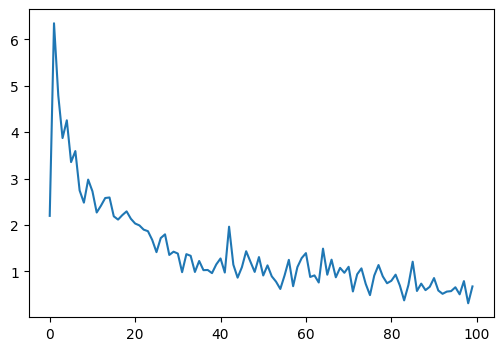

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(losses)
plt.show()